# Download data

In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/env/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


In [3]:

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/642"
mip = 0

vol = CloudVolume(dir, parallel=True, mip=mip, fill_missing=True)
shape = vol.shape
print(shape)

[ 7403 10240  4800     1]


In [80]:
centers = [[3104, 3700, 2373], [2365, 3753, 2373], [3615, 3671, 2373], [2556, 5182, 2373], [2231, 4961, 2719], [2570, 6194, 2493], [2647, 4247, 1911], [3623, 3732, 2423], [2681, 3426, 2436], [3603, 3669, 2490]]
#0, 1, 4, 5, 8 - thin more obvious axons
#2, 3, 6,7,9 - thick and faint

centers_off = [[2013, 3983, 675], [4847,3584,1625], [2992,6649,1625], [2272,5195,1927], [4754,4971,2294], [4801,5284,2294], [3853,6437,3325], [4887,6007,3325], [1990,6043,3325], [2872,2444,3898]]

#one axon? - 0,4,6,7,8,9
#def not - 1,2,3,5
i=2
center = centers[i]
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/on_" + str(i) + ".tif"
image = io.imread(fname)
radius = 100
#image = vol[center[0]-radius:center[0]+radius,center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
#image = image[:,:,:,0]
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)

<Image layer 'image' at 0x180940dc0>

## Grad random subvolumes

In [2]:
import random

In [68]:
center = [random.randint(100,shape[0]-100), random.randint(100,shape[1]-100), random.randint(100,shape[2]-100)]

[4369, 6951, 2393]


In [78]:
centers = [[2636, 2786, 3978], [5391, 1147, 3026],[5544, 1113, 2885],[5542, 482, 3570],[3040, 2916, 2633],[4229, 7898, 3646],[5240, 3523, 4025],[1285, 3131, 2060],[1154, 4651, 880],[4369, 6951, 2393]]
center = [2365, 3753, 2373]
radius = 100
image = vol[center[0]-radius:center[0]+radius,center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
image = image[:,:,:,0]
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)

<Image layer 'image' at 0x1710bc1f0>

In [79]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/on_1.tif"
io.imsave(fname, image)

<ipython-input-79-b4226c87eead>:2: UserWarning: /Users/thomasathey/Documents/mimlab/mouselight/ailey/on_1.tif is a low contrast image
  io.imsave(fname, image)


## Write tifs

In [3]:
from skimage import io 

In [51]:
for i in range(8,9):
    center = centers[i]
    radius = 100
    image = vol[center[0]-radius:center[0]+radius,center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image = image[:,:,:,0]
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/on_" + str(i) + ".tif"
    io.imsave(fname, image)

<ipython-input-51-ff163b6c411a>:7: UserWarning: /Users/thomasathey/Documents/mimlab/mouselight/ailey/on_8.tif is a low contrast image
  io.imsave(fname, image)



### Read ilastik

In [7]:
import h5py
import numpy as np 
from skimage import io 

In [8]:
base_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/"

part = "0"

im_path  = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/" + part + ".tif"
image = io.imread(im_path)

pred_path = base_path + part + "_Probabilities.h5"
f = h5py.File(pred_path, 'r')
pred = f['exported_data'].value
pred = pred[:,:,:,1]

<ipython-input-8-b7b01bf12123>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  pred = f['exported_data'].value


### Read swcs

In [9]:
from brainlit.utils.Neuron_trace import NeuronTrace
from pathlib import Path

In [28]:
swc_path = Path("/Users/thomasathey/Documents/mimlab/mouselight/ailey/" + part + "_traces/")

swc_files = list(swc_path.glob("**/*.swc"))

for swc_num, swc in enumerate(swc_files):

    swc_trace = NeuronTrace(path=str(swc))
    paths = swc_trace.get_paths()
    swc_offset, _, _, _ = swc_trace.get_df_arguments()
    offset_diff = np.subtract(swc_offset, im_offset)

    for path_num, p in enumerate(paths):
        pvox = (p + offset_diff) / (scale) * 1000
        paths_total.append(pvox)

/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/utils/Neuron_trace.py:710: UserWarning: No offset information found in: /Users/thomasathey/Documents/mimlab/mouselight/ailey/0_traces/0-000.swc
  warnings.warn("No offset information found in: " + path)


ValueError: invalid literal for int() with base 10: '1\t0\t39.000000'

In [6]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)
viewer.add_labels(pred>0.5)

<Labels layer 'Labels' at 0x15385a9a0>

In [13]:
import matplotlib.pyplot as plt

(array([1.570480e+05, 2.620451e+06, 3.844695e+06, 1.063487e+06,
        2.746670e+05, 3.552500e+04, 3.455000e+03, 5.440000e+02,
        1.140000e+02, 1.400000e+01]),
 array([1339. , 1721.6, 2104.2, 2486.8, 2869.4, 3252. , 3634.6, 4017.2,
        4399.8, 4782.4, 5165. ]),
 <BarContainer object of 10 artists>)

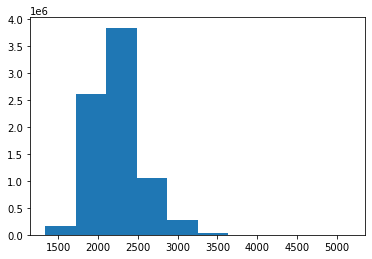

In [14]:
plt.hist(image.flatten())